In [2]:
import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import pytz #세계시간대 변환
import datetime
import requests
import re
import sympy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
import seaborn as sns
import json
sns.set()
sns.set_color_codes()
import scipy as sp
%matplotlib inline
import statsmodels.stats.api as sms
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ipykernel import kernelapp as app
from patsy import dmatrix, dmatrices


/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#1. 전처리
#2. 조건부 확률 기반 판별 모형
#3 . 판별모형에 fitting
claim = pd.read_csv("CLAIM.csv", encoding='euc_kr')
cntt = pd.read_csv("CNTT.csv",encoding='euc_kr')
cust = pd.read_csv("CUST.csv",encoding='euc_kr')

#cust 열제거
cust = cust.dropna(subset=['SIU_CUST_YN'])

#cntt 열제거
cust_id = cust.CUST_ID
cntt_new = cntt.loc[cntt['CUST_ID'].isin(cust_id)]
poly_no = cntt_new.POLY_NO

#claim 열제거
claim_new = claim.loc[claim['POLY_NO'].isin(poly_no)]

# simple merge
claim_cust = pd.merge(claim_new, cust, on='CUST_ID')
claim_cust_cntt = pd.merge(claim_cust, cntt_new, on='POLY_NO')

# target column 변경 (Y/N -> 0/1)
claim_cust_cntt['FRAUD_YN'] = claim_cust_cntt['SIU_CUST_YN'].replace('Y',1).replace('N',0)
del claim_cust_cntt['SIU_CUST_YN']

gf = claim_cust_cntt
#############

# 결측값제거
#data['LTBN_CHLD_AGE'].fillna(0, inplace=True)
#최대보험료 (MAX_PRM) - 일단 평균으로 처리
#data['MAX_PRM'].fillna(np.mean(data['MAX_PRM']),inplace=True)
#data_fraud=data[data['FRAUD_YN'] != 0]  #data_fraud : 보험사기자들만 분리

gf1 = gf.copy()
target = gf['FRAUD_YN']
del gf['FRAUD_YN']

del gf['ACCI_OCCP_GRP1']

df1 = pd.get_dummies(gf1['ACCI_OCCP_GRP2'],prefix=['ACCI_OCCP_GRP2'])
del gf['ACCI_OCCP_GRP2']

df2 = pd.get_dummies(gf1['CHANG_FP_YN'],prefix=['CHANG_FP_YN'])
del gf['CHANG_FP_YN']

del gf['CNTT_RECP_SQNO']
del gf['RECP_DATE']
del gf['ORIG_RESN_DATE']




# del gf['PAYM_DATE']
# del gf['RESN_DATE']

df3 = pd.get_dummies(gf1['CRNT_PROG_DVSN'],prefix=['CRNT_PROG_DVSN'])
del gf['CRNT_PROG_DVSN']

df4 = pd.get_dummies(gf1['ACCI_DVSN'],prefix=['ACCI_DVSN'])
del gf['ACCI_DVSN']

del gf['CAUS_CODE']
del gf['CAUS_CODE_DTAL']
del gf['DSAS_NAME']

df5 = pd.get_dummies(gf1['DMND_RESN_CODE'],prefix=['DMND_RESN_CODE'])
del gf['DMND_RESN_CODE']
del gf['DMND_RSCD_SQNO']

#입원통원시작일자, 시작종료  - 두개뺴기 +1, 변수생성 STDT_ENDT
gf['HOSP_OTPA_STDT'].fillna(20000101,inplace =True)
gf['HOSP_OTPA_ENDT'].fillna(20000101,inplace =True)
stdt = [datetime.datetime.strptime(str(int(t)),'%Y%m%d') for t in gf['HOSP_OTPA_STDT']]
endt = [datetime.datetime.strptime(str(int(t)),'%Y%m%d') for t in gf['HOSP_OTPA_ENDT']]
# date2 = datetime.datetime.strptime(gf['RESN_DATE'],'%Y%m%d')
# date3 = datetime.datetime.strptime(gf['CNTT_YM'],'%Y%m')
delta0 = []

for i in range(len(stdt)):
    delta0.append((endt[i] - stdt[i]).days)
    
#PAYM_RESN_DATE 보험금 지급일 - 지급사유발생일
#PAYM_CNTT_DAYS 보험금 지급일 - 계약일
gf['HOSP_STDT_ENDT'] = delta0
del gf['HOSP_OTPA_STDT']
del gf['HOSP_OTPA_ENDT']



del gf['RESL_CD1']
del gf['RESL_NM1']

#고객 병원 거리 HOUSE_HOSP_DIST
gf['HOUSE_HOSP_DIST'].fillna(np.mean(gf['HOUSE_HOSP_DIST']),inplace=True)

#병원코드 HOSP_CODE
gf['HOSP_CODE'].fillna(0, inplace=True) 

#병원 지역 (시도) ACCI_HOSP_ADDR  
gf['ACCI_HOSP_ADDR'].fillna('기타', inplace=True)

#병원종별구분 HOSP_SPEC_DVSN 99기타
gf['HOSP_SPEC_DVSN'].fillna(99, inplace=True)
df6 = pd.get_dummies(gf1['HOSP_SPEC_DVSN'],prefix=['HOSP_SPEC_DVSN'])
del gf['HOSP_SPEC_DVSN']

del gf['CHME_LICE_NO']
del gf['DMND_AMT']
del gf['PMMI_DLNG_YN']
del gf['SELF_CHAM']
del gf['NON_PAY']
del gf['TAMT_SFCA']
del gf['PATT_CHRG_TOTA']
del gf['DSCT_AMT']
del gf['COUNT_TRMT_ITEM']
del gf['NON_PAY_RATIO']

df7 = pd.get_dummies(gf1['HEED_HOSP_YN'],prefix=['HEED_HOSP_YN'])
del gf['HEED_HOSP_YN']
####CUST

del gf['DIVIDED_SET']

#거주타입 RESI_TYPE_CODE
gf['RESI_TYPE_CODE'].fillna(99, inplace=True)

del gf['FP_CAREER']
del gf['CUST_RGST']

#시도구분 CTPR
gf['CTPR'].fillna('기타', inplace=True)
df8 = pd.get_dummies(gf1['CTPR'],prefix=['CTPR'])
del gf['CTPR']


del gf['OCCP_GRP_1']
del gf['OCCP_GRP_2']


gf['TOTALPREM'].fillna(0, inplace=True)
gf['TOTALPREM'].fillna(np.median(gf['TOTALPREM']),inplace=True)

#거주타입 RESI_TYPE_CODE
gf['RESI_TYPE_CODE'].fillna(99, inplace=True)

#신용등급최소 MINCRDT 신용등급최대 MAXCRDT
gf['MINCRDT'].fillna(99, inplace=True)
gf['MAXCRDT'].fillna(99, inplace=True)

del gf['WEDD_YN']
del gf['MATE_OCCP_GRP_1']
del gf['MATE_OCCP_GRP_2']

#자녀수 CHLD_CNT
# gf['CHLD_CNT'].fillna(0, inplace=True)
del gf['CHLD_CNT']
#막내자녀연령 LTBN_CHLD_AGE
# gf['LTBN_CHLD_AGE'].fillna(0, inplace=True)
del gf['LTBN_CHLD_AGE']

#지급일자, 최대보험료년월  - 두개뺴기 , 변수생성 PAYM_DATE   MAX_PAYM_YM
# gf['PAYM_DATE'].fillna(0, inplace=True) 
# gf['MAX_PAYM_YM'].fillna(0, inplace=True) 
# gf['PAYM_MAX']=(gf['PAYM_DATE']-gf['MAX_PAYM_YM'])
# del gf['PAYM_DATE']
# del gf['MAX_PAYM_YM']

#CUST_INCM
gf['MNTH_INCM_AMT'].fillna(0, inplace=True)
gf['CUST_INCM'].fillna((gf['MNTH_INCM_AMT']*12/10000),inplace=True)


gf['RCBASE_HSHD_INCM'].fillna(0, inplace=True)
gf['JPBASE_HSHD_INCM'].fillna(0, inplace=True)
gf['AVR_HSHD_INCM'] = (gf['RCBASE_HSHD_INCM']+gf['JPBASE_HSHD_INCM'])/2


del gf['MAX_PRM']
# del data['CUST_INCM']
del gf['RCBASE_HSHD_INCM']
del gf['JPBASE_HSHD_INCM']



df9 = pd.get_dummies(gf1['CUST_ROLE'],prefix=['CUST_ROLE'])
del gf['CUST_ROLE']
del gf['IRKD_CODE_DTAL']
del gf['IRKD_CODE_ITEM']
del gf['GOOD_CLSF_CDNM']




#############

date1 = [datetime.datetime.strptime(str(int(t)),'%Y%m%d') for t in gf['PAYM_DATE']]
date2 = [datetime.datetime.strptime(str(int(t)),'%Y%m%d') for t in gf['RESN_DATE']]
date3 = [datetime.datetime.strptime(str(int(t)),'%Y%m') for t in gf['CNTT_YM']]


# date2 = datetime.datetime.strptime(gf['RESN_DATE'],'%Y%m%d')
# date3 = datetime.datetime.strptime(gf['CNTT_YM'],'%Y%m')
delta1 = []
delta2 = []
for i in range(len(date1)):
    delta1.append((date1[i] - date2[i]).days)
    delta2.append((date1[i] - date3[i]).days)
#PAYM_RESN_DATE 보험금 지급일 - 지급사유발생일
#PAYM_CNTT_DAYS 보험금 지급일 - 계약일
gf['PAYM_RESN_DATE'] = delta1
gf['PAYM_CNTT_DAYS'] = delta2

########################


del gf['PAYM_DATE']
del gf['RESN_DATE']
del gf['CNTT_YM']


del gf['CLLT_FP_PRNO']
del gf['REAL_PAYM_TERM']

df10 = pd.get_dummies(gf1['SALE_CHNL_CODE'],prefix=['SALE_CHNL_CODE'])
df11 = pd.get_dummies(gf1['CNTT_STAT_CODE'],prefix=['CNTT_STAT_CODE'])
del gf['SALE_CHNL_CODE']


#계약상태코드 CNTT_STAT_CODE 
gf['CNTT_STAT_CODE'].fillna(1, inplace=True)



del gf['EXPR_YM']
del gf['EXTN_YM']
del gf['LAPS_YM']


#납입주기코드 PAYM_CYCL_CODE
gf['PAYM_CYCL_CODE'].fillna(1, inplace=True)

del gf['MAIN_INSR_AMT']

#합계보험료 SUM_ORIG_PREM
gf['SUM_ORIG_PREM'].fillna(0, inplace=True)
gf['SUM_ORIG_PREM'].fillna(np.median(gf['SUM_ORIG_PREM']),inplace=True)

del gf['RECP_PUBL']
del gf['CNTT_RECP']

del gf['DCAF_CMPS_XCPA']
del gf['MAX_PAYM_YM']

#청약서소득 MNTH_INCM_AMT
gf['MNTH_INCM_AMT'].fillna(0, inplace=True)

#FP와 고객의 거리 DISTANCE
gf['DISTANCE'].fillna(np.mean(gf['DISTANCE']),inplace=True)

df12 = pd.get_dummies(gf1['ACCI_HOSP_ADDR'],prefix=['ACCI_HOSP_ADDR'])
del gf['ACCI_HOSP_ADDR']
df13 = gf['SEX']
del gf['SEX']

df14 = pd.get_dummies(gf1['RESI_TYPE_CODE'],prefix=['RESI_TYPE_CODE'])
df15 = pd.get_dummies(gf1['CNTT_STAT_CODE'],prefix=['CNTT_STAT_CODE'])
df16 = pd.get_dummies(gf1['PAYM_CYCL_CODE'],prefix=['PAYM_CYCL_CODE'])

del gf['RESI_TYPE_CODE']
del gf['CNTT_STAT_CODE']
del gf['PAYM_CYCL_CODE']
del gf['HOSP_CODE']


del gf['CUST_ID_x']
del gf['CUST_ID_y']
del gf['POLY_NO']
########################


In [18]:
#변수선택 

# PAYM_RESN_DATE_log = np.log(gf["PAYM_RESN_DATE"]+0.1)
PAYM_CNTT_DAYS_log = np.log(gf["PAYM_CNTT_DAYS"]+0.1)
VLID_HOSP_OTDA_log = np.log(gf["VLID_HOSP_OTDA"]+0.1)
# HOUSE_HOSP_DIST_log = np.log(gf["HOUSE_HOSP_DIST"]+0.1)
PAYM_AMT_log = np.log(gf["PAYM_AMT"]+0.1)
# AGE_log = np.log(gf["AGE"]+0.1)
RESI_COST_log = np.log(gf["RESI_COST"]+0.1)
TOTALPREM_log = np.log(gf["TOTALPREM"]+0.1)
# MINCRDT_log = np.log(gf["MINCRDT"]+0.1)
# MAXCRDT_log = np.log(gf["MAXCRDT"]+0.1)
# CUST_INCM_log = np.log(gf["CUST_INCM"]+0.1)
# SUM_ORIG_PREM_log = np.log(gf["SUM_ORIG_PREM"]+0.1)
# MNTH_INCM_AMT_log = np.log(gf["MNTH_INCM_AMT"]+0.1)
DISTANCE_log = np.log(gf["DISTANCE"]+0.1)
# HOSP_STDT_ENDT_log = np.log(gf["HOSP_STDT_ENDT"]+0.1) 
AVR_HSHD_INCM_log = np.log(gf["AVR_HSHD_INCM"]+0.1)

#log= pd.concat([PAYM_RESN_DATE_log,PAYM_CNTT_DAYS_log,AVR_HSHD_INCM_log,HOSP_STDT_ENDT_log,DISTANCE_log,MNTH_INCM_AMT_log,SUM_ORIG_PREM_log,CUST_INCM_log,MAXCRDT_log,MINCRDT_log,TOTALPREM_log,RESI_COST_log,AGE_log,PAYM_AMT_log,HOUSE_HOSP_DIST_log,VLID_HOSP_OTDA_log], axis=1)
log = pd.concat([TOTALPREM_log,VLID_HOSP_OTDA_log,PAYM_CNTT_DAYS_log,PAYM_AMT_log,RESI_COST_log,DISTANCE_log,AVR_HSHD_INCM_log],axis=1)

In [5]:
#gf2 = pd.concat([df1,df2,df3,df5,df6,df7,df8,df9,df10,df11,df12,df13, df14, df15, df16],axis=1)
#data = pd.concat([gf,gf2],axis=1)
data = pd.concat([log,gf2],axis=1)

In [19]:
gf2 = pd.concat([df1,df3,df10,df5,df11,df6],axis=1)
data = pd.concat([log,gf2],axis=1)

In [8]:
data.ix[:,0:7].head()

,TOTALPREM,VLID_HOSP_OTDA,PAYM_CNTT_DAYS,PAYM_AMT,RESI_COST,DISTANCE,AVR_HSHD_INCM
0,15.349931,0.741937,6.761689,9.903493,10.081136,-2.302585,9.196606
1,15.349931,0.741937,7.281454,9.903493,10.081136,-2.302585,9.196606
2,15.349931,0.741937,6.210801,10.308956,10.081136,-2.302585,9.196606
3,15.349931,0.741937,6.991269,10.308956,10.081136,-2.302585,9.196606
4,15.349931,0.741937,5.416545,10.596637,10.081136,-2.302585,9.196606


In [20]:
#2. 조건부 확률 기반 판별 모형

class DiscFunction():
    def __init__(self):
        pass
        
    
    def seperateDF(self,df):
        df0 = pd.DataFrame(df)
        df1 = df0.ix[:,0:7]
        df2 = df0.ix[:,7:-1]
        return (df1, df2)
    
    def seperateArr(self, arr):
        arr1 = arr[0:7]
        arr2 = arr[7:-1]
        return (arr1,arr2)
    def fit(self,df,y):
        df1, df2 = self.seperateDF(df)
        self.clf = GaussianNB().fit(df1, y)
        self.clf_cat = MultinomialNB().fit(df2,y)
    
    
    
    # series 처리
    def predictSeries(self, X_new):
        Xnum_new, Xcat_new = self.seperateArr(X_new)

        Xcat_new = Xcat_new[np.newaxis,:]
        Xnum_new = Xnum_new[np.newaxis,:]
        pmf0 = np.exp(self.clf_cat.predict_log_proba(Xcat_new))
        pmf1 = pmf0 / np.exp(self.clf_cat.class_log_prior_)
        
        pdf0 = self.clf.predict_proba(Xnum_new)
        pdf1 = pdf0/ self.clf.class_prior_
        result0 = pmf1 * pdf1 * self.clf.class_prior_
        result1 = result0 / result0.sum()
        result = np.round(result1[0,1])
        return result
    
    #Dataframe 처리 , 리턴은 DataFrame
    def predict(self, df_new):
        arr = df_new.values
        return map(lambda x : self.predictSeries(x) , arr)
    
    #판별함수 (=predict), 리턴은 array
    def decision_function(self,df_new):
        arr = self.predict(df_new)
        return map(lambda x :x , arr)
    
    def score(self, df_new, df_y):
        arr = self.predict(df_new)
        y = df_y.values
        s_list = map(lambda x : 1 if arr[x] == y[x] else 0 ,range(len(arr)))
        return np.sum(s_list)/float(len(s_list))

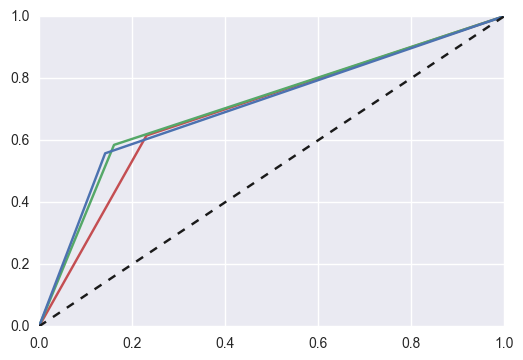

In [21]:
# 3 판별모형 교차검증 Stratified K-Fold  
X = data
y = target
cv = StratifiedKFold(y, n_folds=3, random_state=0)
fpr_list = []
tpr_list = [] 
thresholds_list = []

pre_list = []
rec_list = []
pthresholds_list = []

model1 = DiscFunction()
for train_index, test_index in cv:
    model1.fit(X.iloc[train_index], y[train_index])
    fpr,tpr,thresholds = roc_curve( y[test_index], model1.decision_function(X.iloc[test_index]))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresholds_list.append(thresholds)
    
    pre,rec,pthresholds = precision_recall_curve(y, model1.decision_function(X))
    pre_list.append(pre)
    rec_list.append(rec)
    pthresholds_list.append(pthresholds)
    
plt.plot(fpr_list[0],tpr_list[0], color='r')
plt.plot(fpr_list[1],tpr_list[1], color='g')
plt.plot(fpr_list[2],tpr_list[2], color='b')
# plt.plot(fpr_list[3],tpr_list[3], color='r')
# plt.plot(fpr_list[4],tpr_list[4], color='r')

plt.plot([0,1], [0,1], 'k--', label="random guess")
plt.show()

In [22]:
# 4-1 y=1 데이터 부트스트래핑

yf_index = list(filter(lambda i: target.iloc[i] ==1, range(len(target.index))))
x_fraud1 = X.iloc[yf_index]
y_fraud1 = y[yf_index]

X = data.append(x_fraud1).append(x_fraud1)
X = X.reset_index(drop=True)
y = np.hstack([target.values, y_fraud1, y_fraud1])


[[16741 11731]
 [ 6109 19080]]
             precision    recall  f1-score   support

          0       0.73      0.59      0.65     28472
          1       0.62      0.76      0.68     25189

avg / total       0.68      0.67      0.67     53661

[[18736  9736]
 [ 6218 18971]]
             precision    recall  f1-score   support

          0       0.75      0.66      0.70     28472
          1       0.66      0.75      0.70     25189

avg / total       0.71      0.70      0.70     53661

[[19028  9444]
 [ 6111 19078]]
             precision    recall  f1-score   support

          0       0.76      0.67      0.71     28472
          1       0.67      0.76      0.71     25189

avg / total       0.72      0.71      0.71     53661



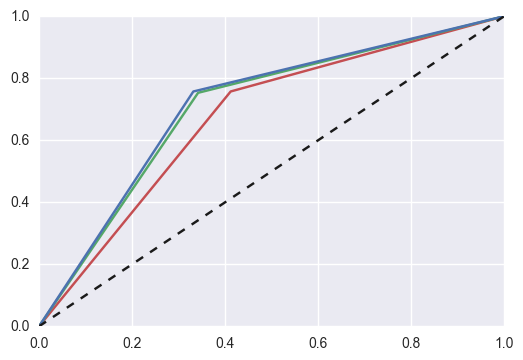

In [23]:
# 4-2 교차검증 Stratified K-Fold
cv = StratifiedKFold(y, n_folds=3, random_state=0)
fpr_list_ext = []
tpr_list_ext = [] 
thresholds_list_ext = []

pre_list_ext = []
rec_list_ext = []
pthresholds_list_ext = []

model1 = DiscFunction()
for train_index, test_index in cv:
    model1.fit(X.iloc[train_index], y[train_index])
    fpr,tpr,thresholds = roc_curve( y[test_index], model1.decision_function(X.iloc[test_index]))
    fpr_list_ext.append(fpr)
    tpr_list_ext.append(tpr)
    thresholds_list_ext.append(thresholds)
    
    pre,rec,pthresholds = precision_recall_curve(y, model1.decision_function(X))
    pre_list_ext.append(pre)
    rec_list_ext.append(rec)
    pthresholds_list_ext.append(pthresholds)
    print(confusion_matrix(y[test_index], model1.predict(X.iloc[test_index])))
    print(classification_report(y[test_index], model1.predict(X.iloc[test_index])))
    
plt.plot(fpr_list_ext[0],tpr_list_ext[0], color='r')
plt.plot(fpr_list_ext[1],tpr_list_ext[1], color='g')
plt.plot(fpr_list_ext[2],tpr_list_ext[2], color='b')


plt.plot([0,1], [0,1], 'k--', label="random guess")
plt.show()

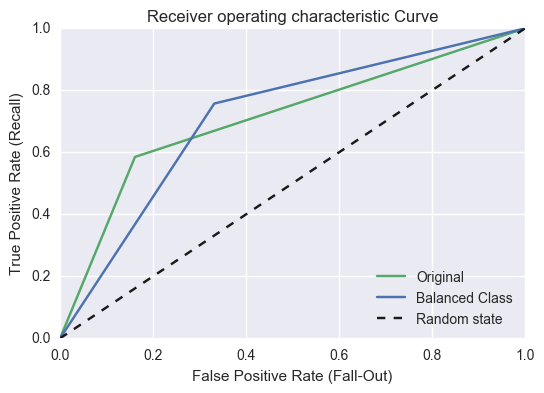

In [24]:
plt.plot(fpr_list[1],tpr_list[1], color='g', label="Original")
plt.plot(fpr_list_ext[2],tpr_list_ext[2], color='b', label="Balanced Class")
plt.plot([0,1],[0,1], 'k--', label="Random state")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc=4)
plt.show()

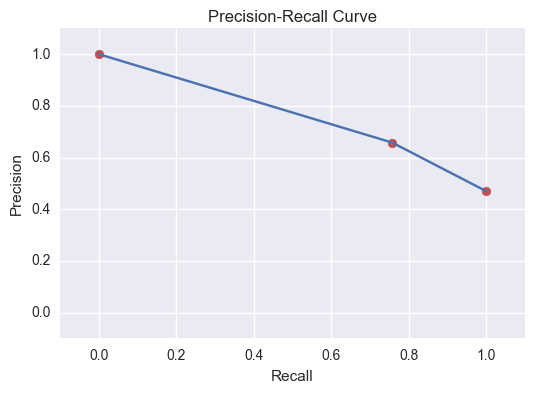

In [25]:
# plt.plot(pre_list[0],rec_list[0], color='r', )
# plt.plot(pre_list[1],rec_list[1], color='g', )
# plt.plot(pre_list[2],rec_list[2], color='b', )
plt.plot(rec_list_ext[0],pre_list_ext[0], color='b', )
# plt.plot(rec_list_ext[1],pre_list_ext[1], color='b', )
# plt.plot(rec_list_ext[2],pre_list_ext[2], color='b', )
plt.scatter(rec_list_ext[0],pre_list_ext[0], color='r', marker='o',s=40)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [26]:
print(pre_list_ext)
print("----------")
print(rec_list_ext)

[array([ 0.46940981,  0.65753802,  1.        ]), array([ 0.46940981,  0.66363106,  1.        ]), array([ 0.46940981,  0.65585681,  1.        ])]
----------
[array([ 1.       ,  0.7574735,  0.       ]), array([ 1.        ,  0.75314621,  0.        ]), array([ 1.       ,  0.7573941,  0.       ])]


In [27]:
#AUC (Area Under the Curve)

from sklearn.metrics import auc
print(auc(fpr_list[0],tpr_list[0]), auc(fpr_list[1],tpr_list[1]),auc(fpr_list[2],tpr_list[2]))
print(auc(fpr_list_ext[0],tpr_list_ext[0]), auc(fpr_list_ext[1],tpr_list_ext[1]),auc(fpr_list_ext[2],tpr_list_ext[2]))


(0.69224707388404505, 0.71200941496512671, 0.70790765274302747)
(0.67272733741233204, 0.70559811433319086, 0.71284990222443201)


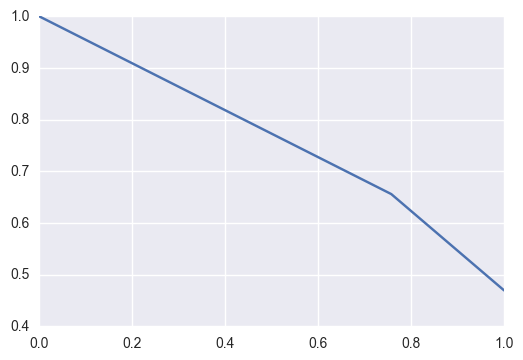

In [28]:
pre, rec, thresholds = precision_recall_curve(y, model1.decision_function(X))
plt.plot(rec, pre)